# IEEE-CIS Fraud Detection(거래 사기 탐지) EDA_KJG

- [IEEE-CIS Fraud Detection(거래 사기 탐지)](https://www.kaggle.com/c/ieee-fraud-detection)
- IEEE-CIS?
    - IEEE Computational Intelligence Society

---

## Data Description

- In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target `isFraud`

- The data is broken into two files `identity` and `transaction`, which are joined by `TransactionID`.  
    - Not all transactions have corresponding identity information.

---

- **Transaction Table**

|Data|Description|
|:----:|:---------:|
| TransactionDT | timedelta from a given reference datetime (not an actual timestamp) |
| TransactionAMT | transaction payment amount in USD |
| ProductCD | product code, the product for each transaction |
| addr | address |
| dist | distance |
| P_ and (R__) emaildomain | purchaser and recipient email domain |
| C1-C14 | counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. |
| D1-D15 | timedelta, such as days between previous transaction, etc. |
| M1-M9 | match, such as names on card and address, etc. |
| Vxxx | Vesta engineered rich features, including ranking, counting, and other entity relations. |

---

- **Identity Table**
|Data|Description|
|:-------:|:--------:|
| DeviceType | 기기 타입 |
| DeviceInfo | [기기 정보](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#583227) |

  
  
- **기기정보**
```
"id01부터 id11은 Vesta와 보안 파트너들이 기기 등급, ip_domain 등급, 프록시 등급 등과 같이 수집한 ID에 대한 수치 기능입니다.
또한 계정 로그인 시간/로그인 실패 시간, 계정이 페이지에 남아 있는 시간 등 행동 지문을 기록했습니다.
이 모든 것은 보안 파트너인 T&C 때문에 자세히 설명할 수 없습니다. 
이러한 기능의 기본적인 의미를 파악하여 수치/범주로 언급함으로써 부적절하게 처리하지 않기를 바랍니다."
```

---

## data 보고 직관적으로 생각해보기

### Transaction Table

- TransactionDT
    - 주어진 reference datetime 으로부터의 timedelta(ms) 값
    - 거래 사기가 많은 시간대가 있는지 확인.
    
- TransactionAMT
    - 거래 금액
    - 거래 금액의 규모에 따라 거래 사기가 많은 거래 금액 규모 확인.
    
- ProductCD **(범주형)**
    - 제품코드
    - 어떤 품목일지 확인해서 거래 사기가 많은 품목 체크 -> 가능🤔?
    
- addr **(범주형)**
    - 주소 
    - 상관 있을까?
    
- dist **(범주형)**
    - 거리
    - 상관 있을까?
    
- P_ and (R__) emaildomain **(범주형)**
    - 구매자와 판매자의 이메일 도메인
    - 거래 사기가 많은 도메인 확인

- C1-C14
    - 개인 정보라서 실제 의미는 알 수 없음.

- D1-D15 
    - timedelta 값 (ex. 이전 거래한 날짜와의 시간 차이)

- M1-M9	**(범주형)**
    - 개인 정보의 일치 정보

- Vxxx
    - Vesta사에서 고객군 관리를 위해 만들어낸 변수
    - 랭킹, 카운팅, 관계, ect

### Identity Table

- 거래와 관련된 식별정보 **(범주형)**
    - 네트워크 연결정보
    - 디지털 서명 정보

- DeviceType
- DeviceInfo
- id12 ~ id38

---

In [50]:
# 필요한 라이브러리 Import

import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [17]:
# raw data path 지정
data_path = "../../data/raw/"

In [18]:
# data 불러오기

## Transaction data loading
### index 통합
train_trans = pd.read_csv( data_path + "train_transaction.csv", index_col='TransactionID')
test_trans = pd.read_csv ( data_path + "test_transaction.csv", index_col='TransactionID')

## Identity data loading
### index 통합
train_id = pd.read_csv( data_path + "train_identity.csv", index_col='TransactionID')
test_id = pd.read_csv( data_path + "test_identity.csv", index_col='TransactionID')

In [19]:
train_trans.head(3)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
train_id.head(3)

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


## 데이터 전처리

In [21]:
# data check function

def data_check(df):
    print("rows:", df.shape[0], 'columns:', df.shape[1])
    
data_check(train_trans)
data_check(test_trans)
data_check(train_id)
data_check(test_id)

rows: 590540 columns: 393
rows: 506691 columns: 392
rows: 144233 columns: 40
rows: 141907 columns: 40


In [22]:
# data merging

## train = train_trans + train_id
train = train_trans.merge(train_id, how='left', left_index=True, right_index=True)

## test = test_trans + test_id
test = test_trans.merge(test_id, how='left', left_index=True, right_index=True)

In [23]:
# merging data check
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.9+ GB


- train의 data는 총 3가지
    
|종류|변수 타입|
|:-:|:-----:|
|float64|연속형 - 실수|
|int64|연속형 - 정수|
|object|범주형|

In [25]:
# 결측치 check

null_df = train.isnull().sum().reset_index()
null_df.columns = ['column_name', 'null_count']
null_df

,column_name,null_count
0,isFraud,0
1,TransactionDT,0
2,TransactionAmt,0
3,ProductCD,0
4,card1,0
...,...,...
428,id_36,449555
429,id_37,449555
430,id_38,449555
431,DeviceType,449730


In [26]:
# 결측치가 없는 column check
null_df[null_df['null_count'] == 0]

,column_name,null_count
0,isFraud,0
1,TransactionDT,0
2,TransactionAmt,0
3,ProductCD,0
4,card1,0
16,C1,0
17,C2,0
18,C3,0
19,C4,0
20,C5,0


In [61]:
# 컬럼수가 너무 많으니 결측치를 비율로 나타내서 확인

null_df['null_ratio'] = null_df['null_count'] / train.shape[0]
null_df.head(5)
null_df.tail()

,column_name,null_count,null_ratio
428,id_36,449555,0.761261
429,id_37,449555,0.761261
430,id_38,449555,0.761261
431,DeviceType,449730,0.761557
432,DeviceInfo,471874,0.799055


In [60]:
null_sort_df = null_df[null_df['null_ratio'] >= 0.5].sort_values(by='null_ratio', ascending=False)

null_sort_df

,column_name,null_count,null_ratio
416,id_24,585793,0.991962
417,id_25,585408,0.991310
400,id_08,585385,0.991271
399,id_07,585385,0.991271
413,id_21,585381,0.991264
...,...,...,...
49,M5,350482,0.593494
51,M7,346265,0.586353
52,M8,346252,0.586331
53,M9,346252,0.586331


In [49]:
null_df1.head(40)

,column_name,null_count,null_ratio
416,id_24,585793,0.991962
417,id_25,585408,0.991310
400,id_08,585385,0.991271
399,id_07,585385,0.991271
413,id_21,585381,0.991264
418,id_26,585377,0.991257
415,id_23,585371,0.991247
414,id_22,585371,0.991247
419,id_27,585371,0.991247
13,dist2,552913,0.936284


<AxesSubplot:xlabel='column_name', ylabel='null_ratio'>

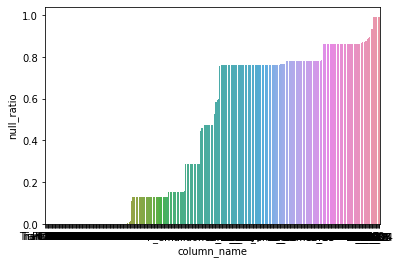

In [13]:
sns.barplot(data=null_df.sort_values(by='null_ratio'), x='column_name', y='null_ratio')

In [14]:
# 그래프를 보면 계단(?) 모양으로 결측 비율이 같은 컬럼들이 존재 -> 확인해보자
## null_ratio 0.2 단위로 끊어서 확인
### df으로 만들기

null_non_df = null_df[null_df['null_ratio'] == 0]
null_00_02_df = null_df[(null_df['null_ratio'] > 0) & (null_df['null_ratio'] <= 0.2)]
null_02_04_df = null_df[(null_df['null_ratio'] > 0.2) & (null_df['null_ratio'] <= 0.4)]
null_04_06_df = null_df[(null_df['null_ratio'] > 0.4) & (null_df['null_ratio'] <= 0.6)]
null_06_08_df = null_df[(null_df['null_ratio'] > 0.6) & (null_df['null_ratio'] <= 0.8)]
null_08_10_df = null_df[(null_df['null_ratio'] > 0.8) & (null_df['null_ratio'] <= 1.0)]

In [19]:
null_non_df.head()

,column_name,null_count,null_ratio
0,isFraud,0,0.0
1,TransactionDT,0,0.0
2,TransactionAmt,0,0.0
3,ProductCD,0,0.0
4,card1,0,0.0


In [18]:
print(null_non_df.info()) # non null
print('-' * 50)
print(null_00_02_df.info()) # 0 ~ 0.2
print('-' * 50)
print(null_02_04_df.info()) # 0.2 - 0.4
print('-' * 50)
print(null_04_06_df.info()) # 0.4 - 0.6
print('-' * 50)
print(null_06_08_df.info()) # 0.6 - 0.8
print('-' * 50)
print(null_08_10_df.info()) # 0.8 - 1.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 29
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   column_name  19 non-null     object 
 1   null_count   19 non-null     int64  
 2   null_ratio   19 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 608.0+ bytes
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 5 to 374
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   column_name  162 non-null    object 
 1   null_count   162 non-null    int64  
 2   null_ratio   162 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.1+ KB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 33 to 105
Data columns (total 3 columns):
 #   Column       Non-Null Co

결측치 비율이 높은 컬럼이 너무 많다!

EDA 를 통해 각 컬럼이 의미하는 바를 이해해보자

## EDA

---

In [ ]:
# raw data path 지정
data_path = "../../data/extracted/"

# data import
train = pd.read_csv( data_path + "train.csv")
test = pd.read_csv ( data_path + "test.csv")
gc.collect();

In [51]:
def plot_numerical(feature):
    """
    Plot some information about a numerical feature for both train and test set.
    Args:
        feature (str): name of the column in DataFrame
    """
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
    sns.kdeplot(train[feature], ax=axes[0][0], label='Train');
    sns.kdeplot(test[feature], ax=axes[0][0], label='Test');

    sns.kdeplot(train[train['isFraud']==0][feature], ax=axes[0][1], label='isFraud 0')
    sns.kdeplot(train[train['isFraud']==1][feature], ax=axes[0][1], label='isFraud 1')

    test[feature].index += len(train)
    axes[1][0].plot(train[feature], '.', label='Train');
    axes[1][0].plot(test[feature], '.', label='Test');
    axes[1][0].set_xlabel('row index');
    axes[1][0].legend()
    test[feature].index -= len(train)

    axes[1][1].plot(train[train['isFraud']==0][feature], '.', label='isFraud 0');
    axes[1][1].plot(train[train['isFraud']==1][feature], '.', label='isFraud 1');
    axes[1][1].set_xlabel('row index');
    axes[1][1].legend()

    pd.DataFrame({'train': [train[feature].isnull().sum()], 'test': [test[feature].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[2][0]);
    pd.DataFrame({'isFraud 0': [train[(train['isFraud']==0) & (train[feature].isnull())][feature].shape[0]],
                  'isFraud 1': [train[(train['isFraud']==1) & (train[feature].isnull())][feature].shape[0]]}).plot(kind='bar', rot=0, ax=axes[2][1]);

    fig.suptitle(feature, fontsize=18);
    axes[0][0].set_title('Train/Test KDE distribution');
    axes[0][1].set_title('Target value KDE distribution');
    axes[1][0].set_title('Index versus value: Train/Test distribution');
    axes[1][1].set_title('Index versus value: Target distribution');
    axes[2][0].set_title('Number of NaNs');
    axes[2][1].set_title('Target value distribution among NaN values');
    
# This code is stolen from Chris Deotte. 
def relax_data(df_train, df_test, col):
    cv1 = pd.DataFrame(df_train[col].value_counts().reset_index().rename({col:'train'},axis=1))
    cv2 = pd.DataFrame(df_test[col].value_counts().reset_index().rename({col:'test'},axis=1))
    cv3 = pd.merge(cv1,cv2,on='index',how='outer')
    factor = len(df_test)/len(df_train)
    cv3['train'].fillna(0,inplace=True)
    cv3['test'].fillna(0,inplace=True)
    cv3['remove'] = False
    cv3['remove'] = cv3['remove'] | (cv3['train'] < len(df_train)/10000)
    cv3['remove'] = cv3['remove'] | (factor*cv3['train'] < cv3['test']/3)
    cv3['remove'] = cv3['remove'] | (factor*cv3['train'] > 3*cv3['test'])
    cv3['new'] = cv3.apply(lambda x: x['index'] if x['remove']==False else 0,axis=1)
    cv3['new'],_ = cv3['new'].factorize(sort=True)
    cv3.set_index('index',inplace=True)
    cc = cv3['new'].to_dict()
    df_train[col] = df_train[col].map(cc)
    df_test[col] = df_test[col].map(cc)
    return df_train, df_test

def plot_categorical(train: pd.DataFrame, test: pd.DataFrame, feature: str, target: str, values: int=5):
    """
    Plotting distribution for the selected amount of most frequent values between train and test
    along with distibution of target
    Args:
        train (pandas.DataFrame): training set
        test (pandas.DataFrame): testing set
        feature (str): name of the feature
        target (str): name of the target feature
        values (int): amount of most frequest values to look at
    """
    df_train = pd.DataFrame(data={feature: train[feature], 'isTest': 0})
    df_test = pd.DataFrame(data={feature: test[feature], 'isTest': 1})
    df = pd.concat([df_train, df_test], ignore_index=True)
    df = df[df[feature].isin(df[feature].value_counts(dropna=False).head(values).index)]
    train = train[train[feature].isin(train[feature].value_counts(dropna=False).head(values).index)]
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    sns.countplot(data=df.fillna('NaN'), x=feature, hue='isTest', ax=axes[0]);
    sns.countplot(data=train[[feature, target]].fillna('NaN'), x=feature, hue=target, ax=axes[1]);
    axes[0].set_title('Train / Test distibution of {} most frequent values'.format(values));
    axes[1].set_title('Train distibution by {} of {} most frequent values'.format(target, values));
    axes[0].legend(['Train', 'Test']);

transform TransctionDT into a datetime

In [52]:
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
train['TransactionDT'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test['TransactionDT'] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

---

### TransactionAmt

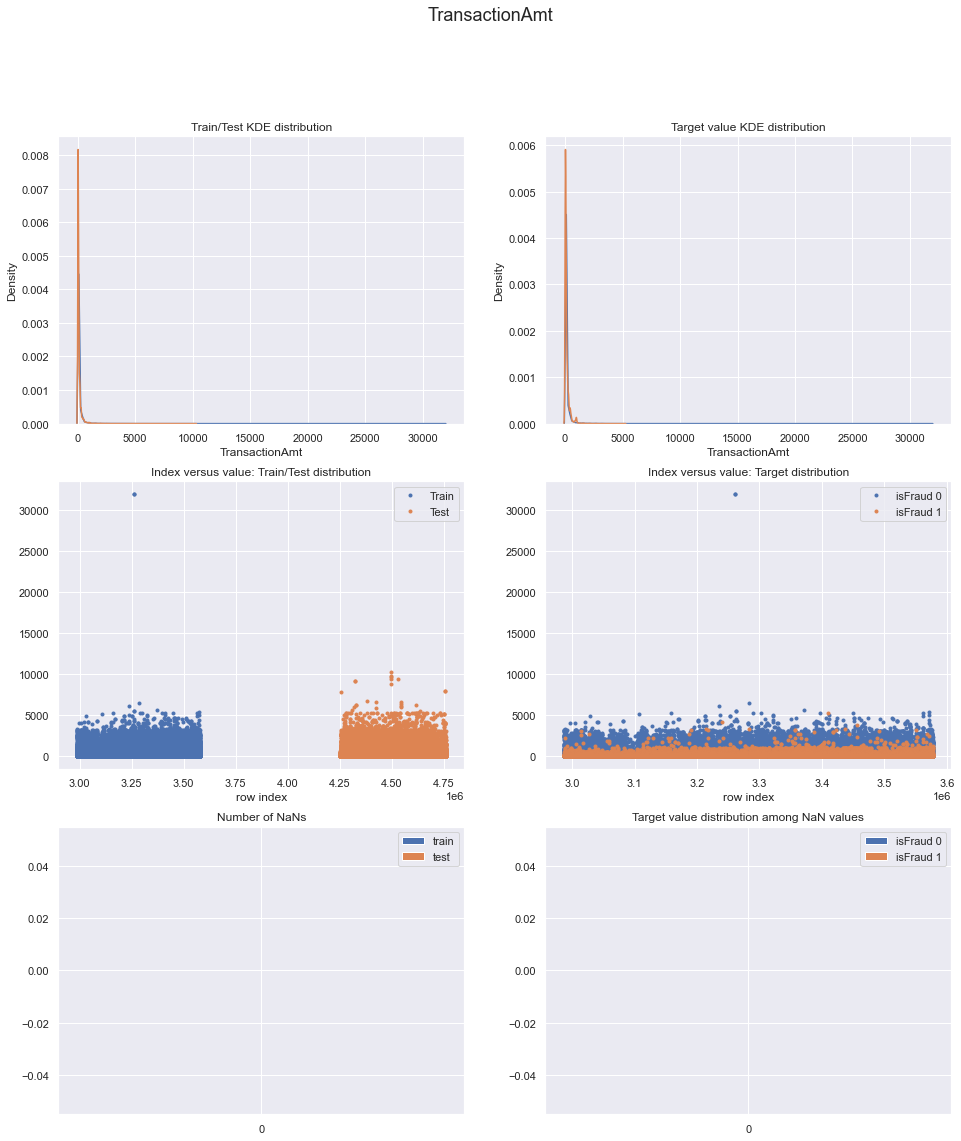

In [53]:
plot_numerical('TransactionAmt')

TransactionDT에 따른 TransactionAmt의 변화

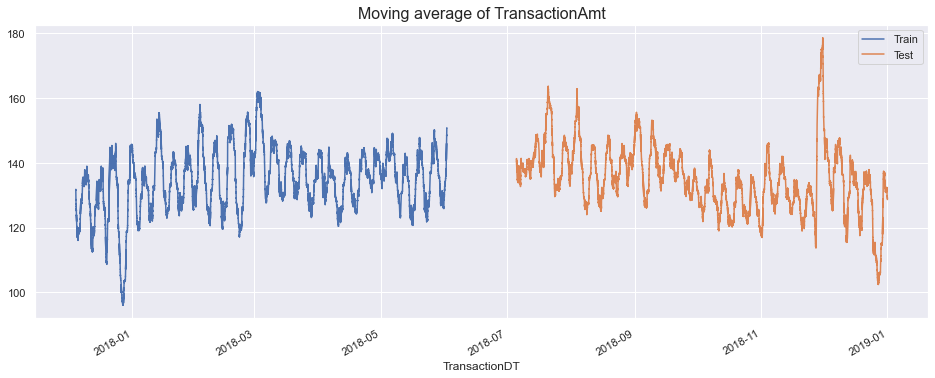

In [54]:
fig, axes = plt.subplots(1,1,figsize=(16, 6))
axes.set_title('Moving average of TransactionAmt', fontsize=16);
train[['TransactionDT', 'TransactionAmt']].set_index('TransactionDT').rolling(10000).mean().plot(ax=axes);
test[['TransactionDT', 'TransactionAmt']].set_index('TransactionDT').rolling(10000).mean().plot(ax=axes);
axes.legend(['Train', 'Test']);

일별 TransactionAmt의 평균

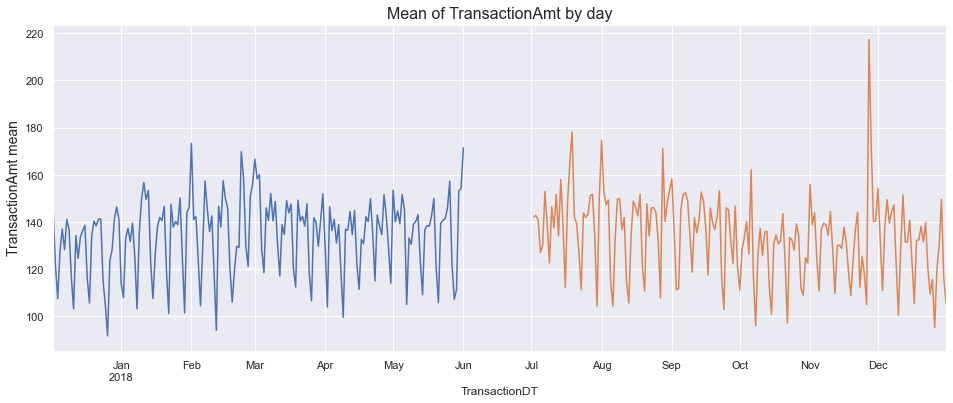

In [55]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['TransactionAmt'].plot(ax=axes).set_ylabel('TransactionAmt mean', fontsize=14);
test.set_index('TransactionDT').resample('D').mean()['TransactionAmt'].plot(ax=axes).set_ylabel('TransactionAmt mean', fontsize=14);
axes.set_title('Mean of TransactionAmt by day', fontsize=16);

일별 TransactionAmt 와 isFraud 의 관계

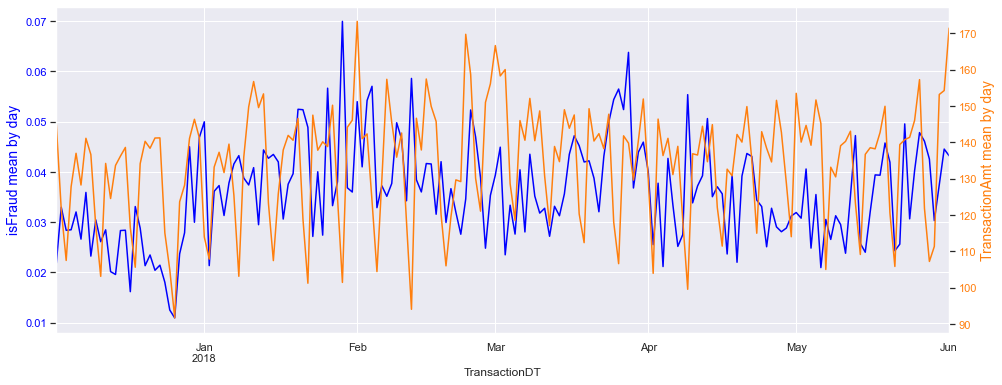

In [56]:
fig, ax1 = plt.subplots(figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=ax1, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylabel('isFraud mean by day', color='blue', fontsize=14)
ax2 = ax1.twinx()
train.set_index('TransactionDT').resample('D').mean()['TransactionAmt'].plot(ax=ax2, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax2.set_ylabel('TransactionAmt mean by day', color='tab:orange', fontsize=14);
ax2.grid(False)

---

### addr